# Notebook for testing the reconstrcution of LST1 MC

<br><br>
<font size="4">This Notebook shows the steps followed within cta-lstchain to reconstruct event data from a corsika-simtelarray file to a dl2 data level, with reconstructed energy, direction and gamma/hadron separation.


<font size="4">
Some imports...

In [26]:
import joblib
from ctapipe.utils import get_dataset_path
from lstchain.io.config import get_standard_config
from copy import copy
import matplotlib.pyplot as plt
import os
import pandas as pd
import lstchain.reco.r0_to_dl1 as calib
import lstchain.reco.dl1_to_dl2 as reco
import lstchain.visualization.plot_dl2 as lstplot
from lstchain.tests.test_lstchain import dl1_file, dl1_params_lstcam_key
import numpy as np
from lstchain.reco.utils import filter_events


%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['font.size'] = 14

<font size="4">
Import a simtelarray file of MC simulated data:

In [3]:
datafile = get_dataset_path('gamma_test_large.simtel.gz')

# Local files can be also imported.
#datafile = "../data/mc/gamma_20deg_180deg_run99___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz"


# Calibration and parameters extraction
<font size="4">
    <br><br>
    We have a function for extracting all the image information:
    
    - Charge extraction
    - Cleaning
    - Hillas Parameters
    - Timing parameters

We store this information in a custom container which we write into a **hdf5** file.

In [9]:
# Limit the number of events to analyze, to speed the examples, if desired.

config = get_standard_config()
config['max_events'] = 1000

output_filename = '../data/mc/dl1_' + os.path.basename(datafile).split('.simtel')[0] + '.h5'
# If the file exists, it complains, so we remove it
!rm $output_filename

calib.r0_to_dl1(datafile, output_filename=output_filename, custom_config=config)


# To speed up and get better results, you can use directly the DL1 file available in 
#output_filename = '/fefs/aswg/data/mc/DL1/20190415/gamma/south_pointing/20200514_v0.5.1_v01/dl1_gamma_south_pointing_20200514_v0.5.1_v01_DL1_testing.h5'

Column mc_tel of container MCEventContainer in table subarray/mc_shower not writable, skipping
Column tel of container TriggerContainer in table subarray/trigger not writable, skipping
Column image_mask of container DL1CameraContainer in table telescope/image/LST_LSTCam not writable, skipping
Column parameters of container DL1CameraContainer in table telescope/image/LST_LSTCam not writable, skipping
Column disp_norm of container DL1ParametersContainer in table telescope/parameters/LST_LSTCam not writable, skipping
Column disp_dx of container DL1ParametersContainer in table telescope/parameters/LST_LSTCam not writable, skipping
Column disp_dy of container DL1ParametersContainer in table telescope/parameters/LST_LSTCam not writable, skipping
Column disp_angle of container DL1ParametersContainer in table telescope/parameters/LST_LSTCam not writable, skipping
Column disp_sign of container DL1ParametersContainer in table telescope/parameters/LST_LSTCam not writable, skipping
Column disp_mis

<font size="4">
We can read this file as a pandas dataframe:

In [10]:
# The results are better if we use the complete DL1 file:

output_filename = '../data/mc/dl1/gamma/dl1_gamma_south_pointing_20201017_v0.6.3_prod5_LST1_local_off0.0deg_DL1_testing.h5'


#Take a look at the parameters extracted from the simtelarray file:

data = pd.read_hdf(output_filename, key=dl1_params_lstcam_key)
print(data.keys())

Index(['intensity', 'log_intensity', 'x', 'y', 'r', 'phi', 'length', 'width',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'obs_id', 'event_id', 'calibration_id', 'mc_energy',
       'log_mc_energy', 'mc_alt', 'mc_az', 'mc_core_x', 'mc_core_y',
       'mc_h_first_int', 'mc_type', 'mc_az_tel', 'mc_alt_tel', 'mc_x_max',
       'mc_core_distance', 'wl', 'tel_id', 'tel_pos_x', 'tel_pos_y',
       'tel_pos_z', 'trigger_type', 'disp_dx', 'disp_dy', 'disp_norm',
       'disp_angle', 'disp_sign', 'src_x', 'src_y'],
      dtype='object')


In [11]:
data.head()

,intensity,log_intensity,x,y,r,phi,length,width,psi,skewness,...,tel_pos_y,tel_pos_z,trigger_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y
0,67.026618,1.826247,-0.334578,-0.097611,0.348526,-2.857729,0.136318,0.046533,0.948247,0.028689,...,-52.07,43.0,0,0.334580,0.097611,0.348527,0.283863,1.0,0.000001,0.0
1,79.036704,1.897829,0.179162,0.656813,0.680810,1.304500,0.073118,0.051160,1.329973,-0.129606,...,-52.07,43.0,0,-0.179160,-0.656813,0.680809,1.304502,-1.0,0.000001,0.0
2,60.488462,1.781673,-0.313192,0.160873,0.352093,2.667081,0.077585,0.042961,-0.536159,-0.231386,...,-52.07,43.0,0,0.313193,-0.160873,0.352094,-0.474511,1.0,0.000001,0.0
3,80.717299,1.906967,-0.181363,-0.251088,0.309738,-2.196339,0.096038,0.072316,0.352101,0.099121,...,-52.07,43.0,0,0.181364,0.251088,0.309739,0.945250,1.0,0.000001,0.0
4,198.061388,2.296800,0.489127,0.318181,0.583510,0.576732,0.175057,0.077006,0.524330,0.118630,...,-52.07,43.0,0,-0.489126,-0.318181,0.583509,0.576733,-1.0,0.000001,0.0


<font size="4">
We can take a look at some of these features...
<br><br>
 
## Energy

In [12]:
plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['font.size'] = 14

Text(0.5, 0, '$log_{10} mcEnergy$ (MeV)')

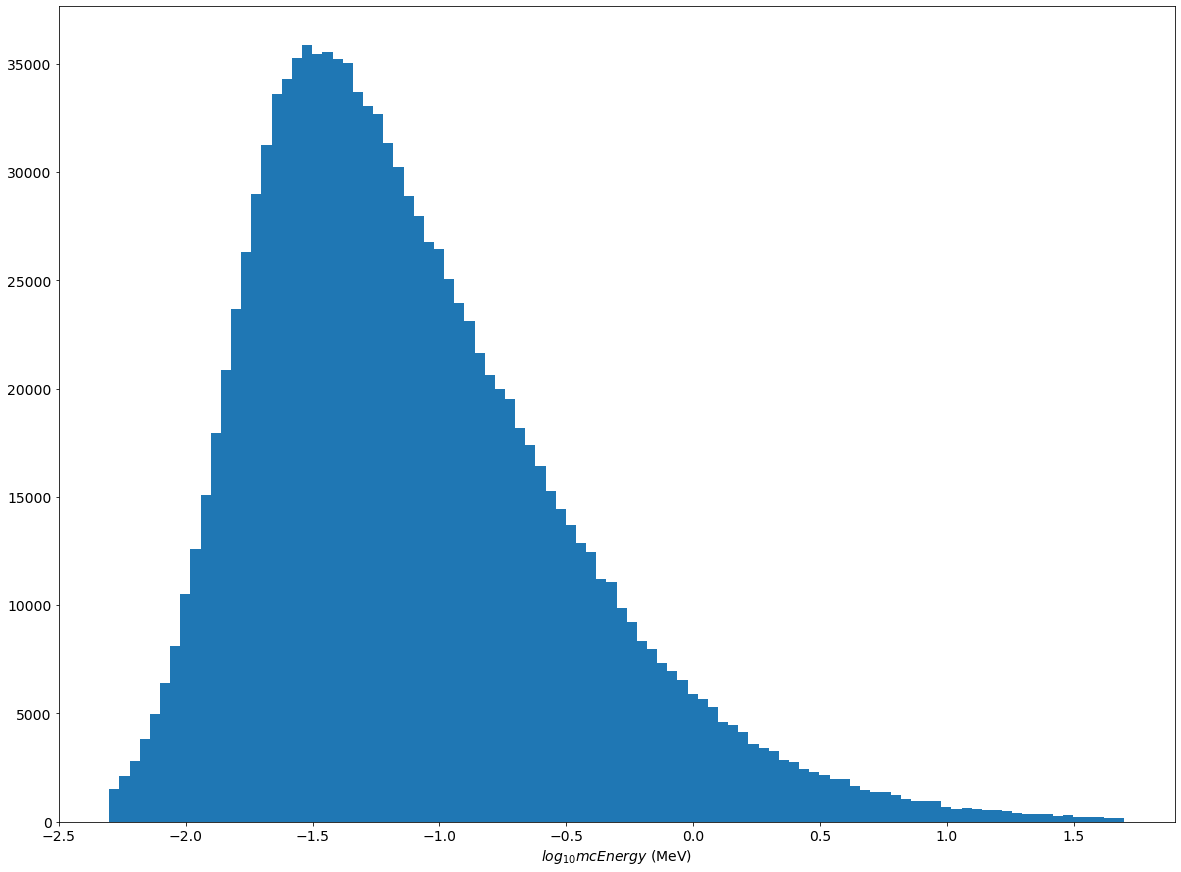

In [13]:
#We can plot some distributions:

plt.hist(data['log_mc_energy'],bins=100) #Log10(Energy) in MeV
plt.xlabel('$log_{10} mcEnergy$ (MeV)')

## Intensity

Text(0.5, 0, '$log_{10} intensity$')

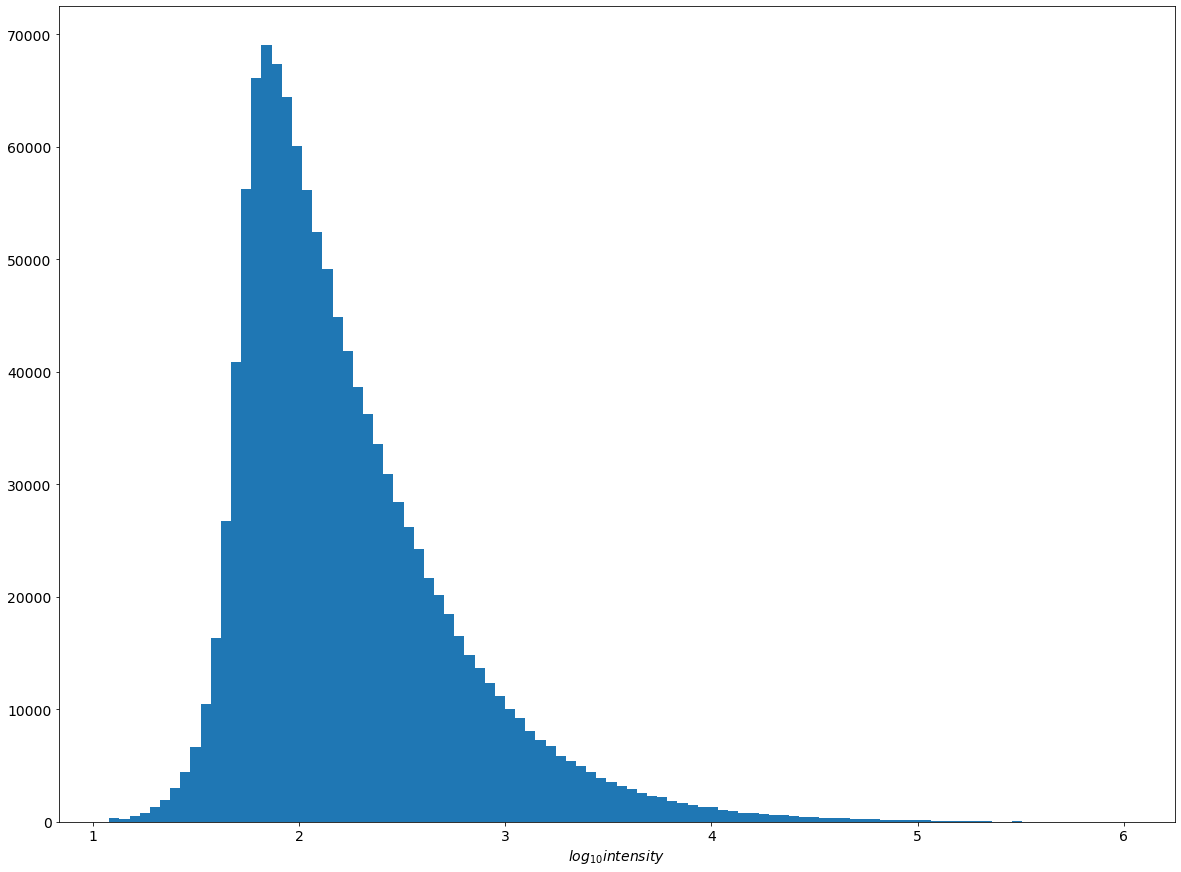

In [14]:
plt.hist(data['log_intensity'],bins=100) #Log10(intensity(size))
plt.xlabel('$log_{10} intensity$')

# Width

Text(0.5, 0, 'width (º)')

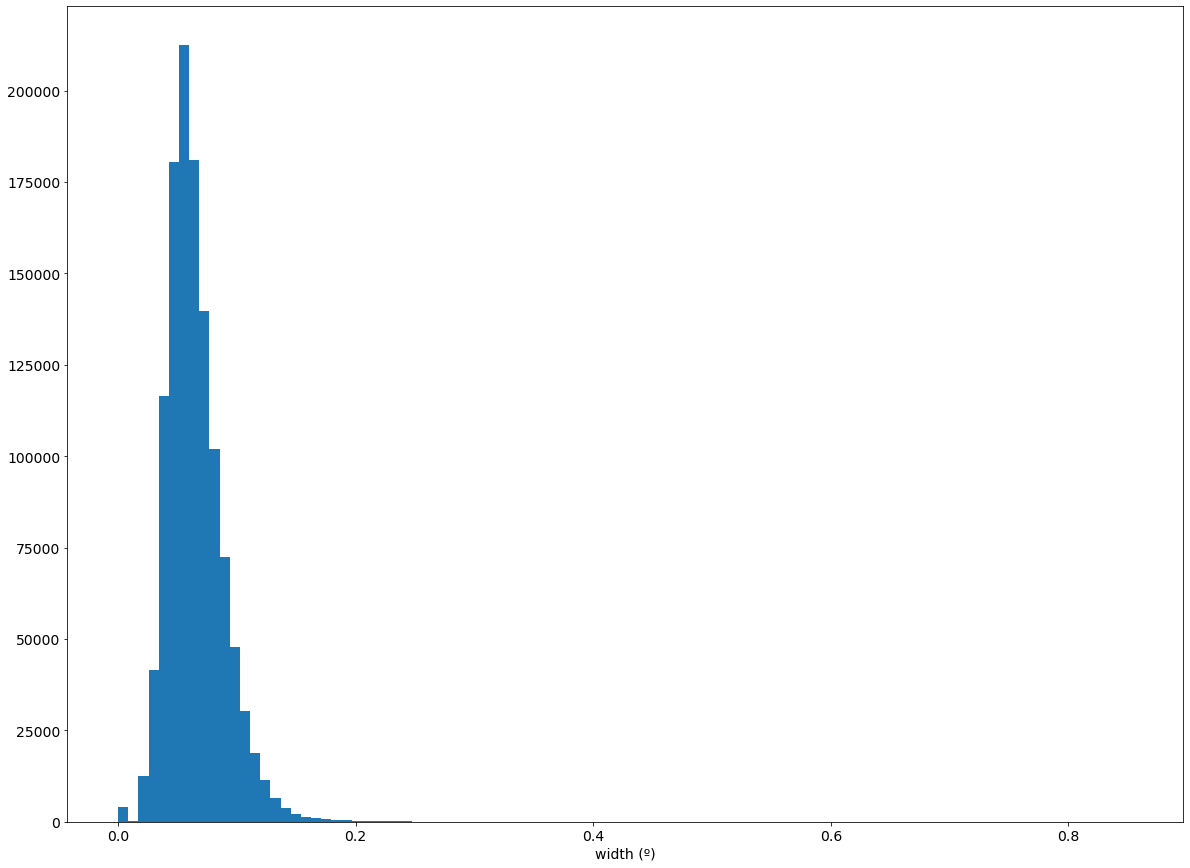

In [15]:
plt.hist(data['width'],bins=100) #Width in deg.
plt.xlabel('width (º)')

# Length

Text(0.5, 0, 'length (º)')

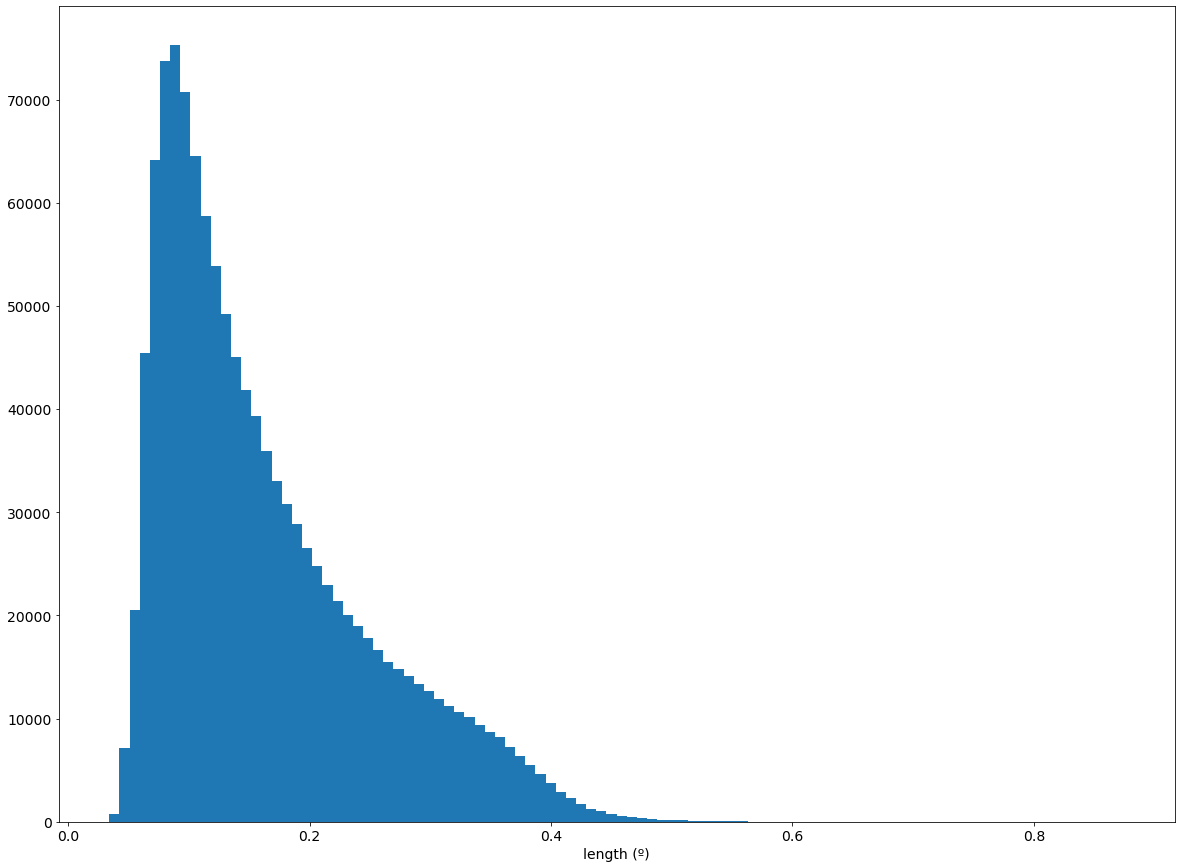

In [16]:
plt.hist(data['length'],bins=100) #Length in deg. 
plt.xlabel('length (º)')

## Source position in camera coordinates

Text(0, 0.5, 'y (m)')

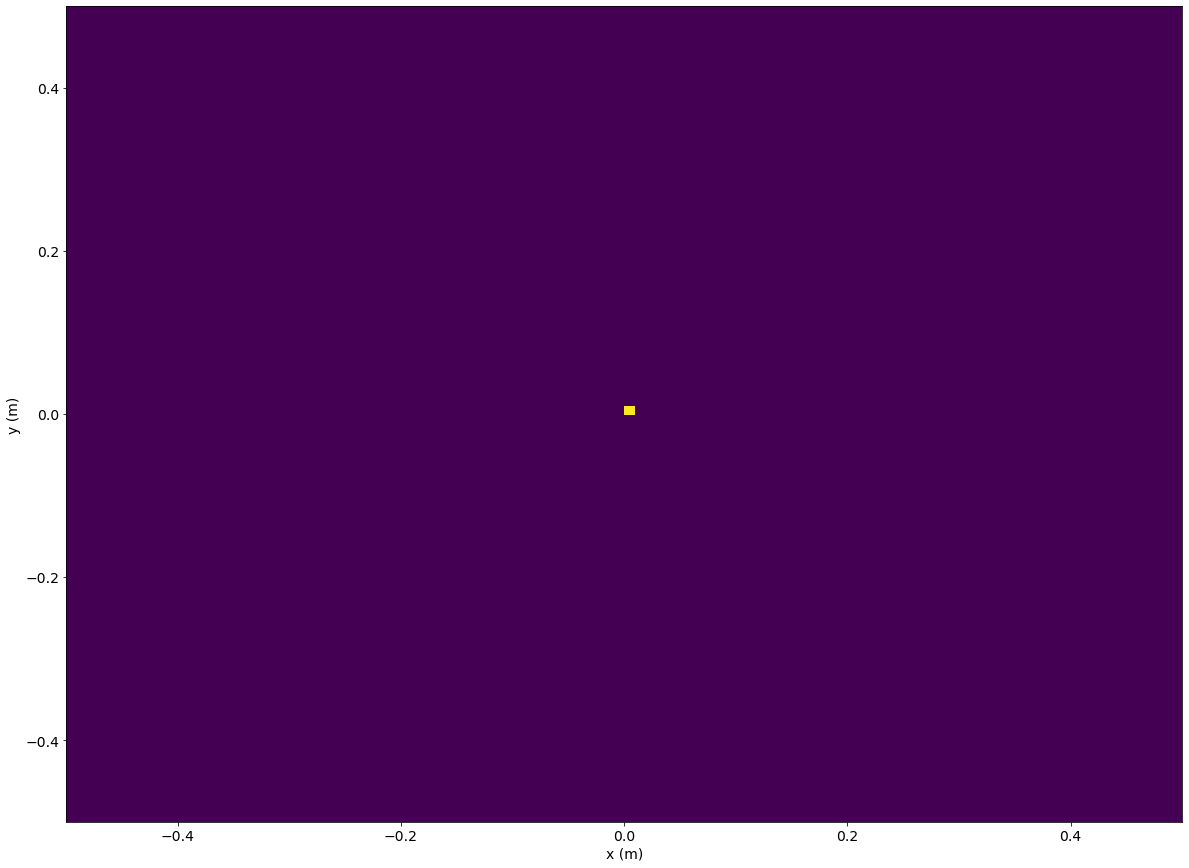

In [17]:
plt.hist2d(data['src_x'],data['src_y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

## Center of gravity of Hillas ellipse in camera coordinates

Text(0, 0.5, 'y (m)')

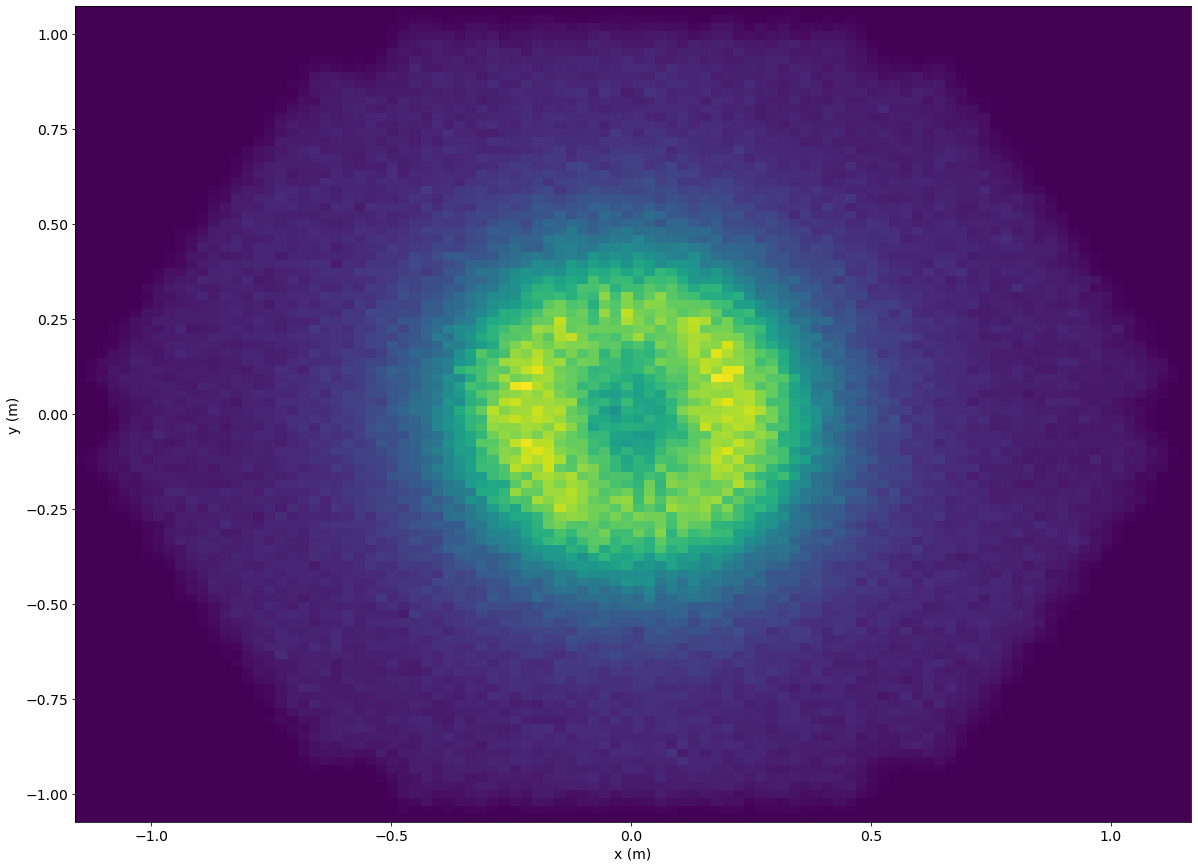

In [18]:
fig, ax = plt.subplots()
ax.hist2d(data['x'],data['y'], 
          range=[[np.min(data.x), np.max(data.x)], 
                 [np.min(data.y), np.max(data.y)]], bins=100)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

# Import the Random Forests previously trained


In [19]:
path_models = "../data/models/"  

fileE = path_models + "/reg_energy.sav"                                                            
fileD = path_models + "/reg_disp_vector.sav"                                                              
fileH = path_models + "/cls_gh.sav"                                                                

RFreg_Energy = joblib.load(fileE)                                                                         
RFreg_Disp = joblib.load(fileD)                                                                           
RFcls_GH = joblib.load(fileH)

/Users/rlopezcoto/opt/anaconda3/envs/lst/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/rlopezcoto/opt/anaconda3/envs/lst/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/rlopezcoto/opt/anaconda3/envs/lst/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/rlopezcoto/opt/anaconda3/envs/lst/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle esti

## Features for prediction:


In [24]:
# We are going to take them from the standard configuration
config = get_standard_config()
config['regression_features']

['log_intensity',
 'width',
 'length',
 'x',
 'y',
 'psi',
 'phi',
 'wl',
 'skewness',
 'kurtosis',
 'r',
 'time_gradient',
 'leakage_intensity_width_2']

<font size="4">
Now we can apply the Random Forests to the data and reconsctruct the energy, direction and Gamma/Hadron classification

In [27]:
#Now we have the trained RF that we can use to reconstruct our data into dl2 format:

data = filter_events(data,
                         filters=config["events_filters"],
                         finite_params=config['regression_features'] + config['classification_features'],
                         )


data_dl2 = reco.apply_models(data, 
                             RFcls_GH, 
                             RFreg_Energy, 
                             RFreg_Disp, 
                             config)
print(data_dl2.keys())

Data contains not-predictable events.
Column | Number of non finite values
log_intensity : 7442
x : 7442
phi : 7442
skewness : 7442
r : 7442
leakage_intensity_width_2 : 7442
wl : 7442
width : 7442
psi : 7442
y : 7442
kurtosis : 7442
length : 7442
time_gradient : 8962
/Users/rlopezcoto/opt/anaconda3/envs/lst/lib/python3.7/site-packages/ctapipe/coordinates/__init__.py:46: MissingFrameAttributeWarning: AltAz coordinate has no obstime, assuming same frame
  MissingFrameAttributeWarning,
/Users/rlopezcoto/opt/anaconda3/envs/lst/lib/python3.7/site-packages/ctapipe/coordinates/__init__.py:54: MissingFrameAttributeWarning: Horizontal coordinate has no location, assuming same frame
  MissingFrameAttributeWarning,


Index(['intensity', 'log_intensity', 'x', 'y', 'r', 'phi', 'length', 'width',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'obs_id', 'event_id', 'calibration_id', 'mc_energy',
       'log_mc_energy', 'mc_alt', 'mc_az', 'mc_core_x', 'mc_core_y',
       'mc_h_first_int', 'mc_type', 'mc_az_tel', 'mc_alt_tel', 'mc_x_max',
       'mc_core_distance', 'wl', 'tel_id', 'tel_pos_x', 'tel_pos_y',
       'tel_pos_z', 'trigger_type', 'disp_dx', 'disp_dy', 'disp_norm',
       'disp_angle', 'disp_sign', 'src_x', 'src_y', 'log_reco_energy',
       'reco_energy', 'reco_disp_dx', 'reco_disp_dy', 'reco_src_x',
       'reco_src_y', 'reco_alt', 'reco_az', 'reco_type', 'gammaness'],
      dtype='object')



# Plot the results

    
## Features:
Since we were using a file only with gamma events, here we can notice the events that has been badly classified as protons.    

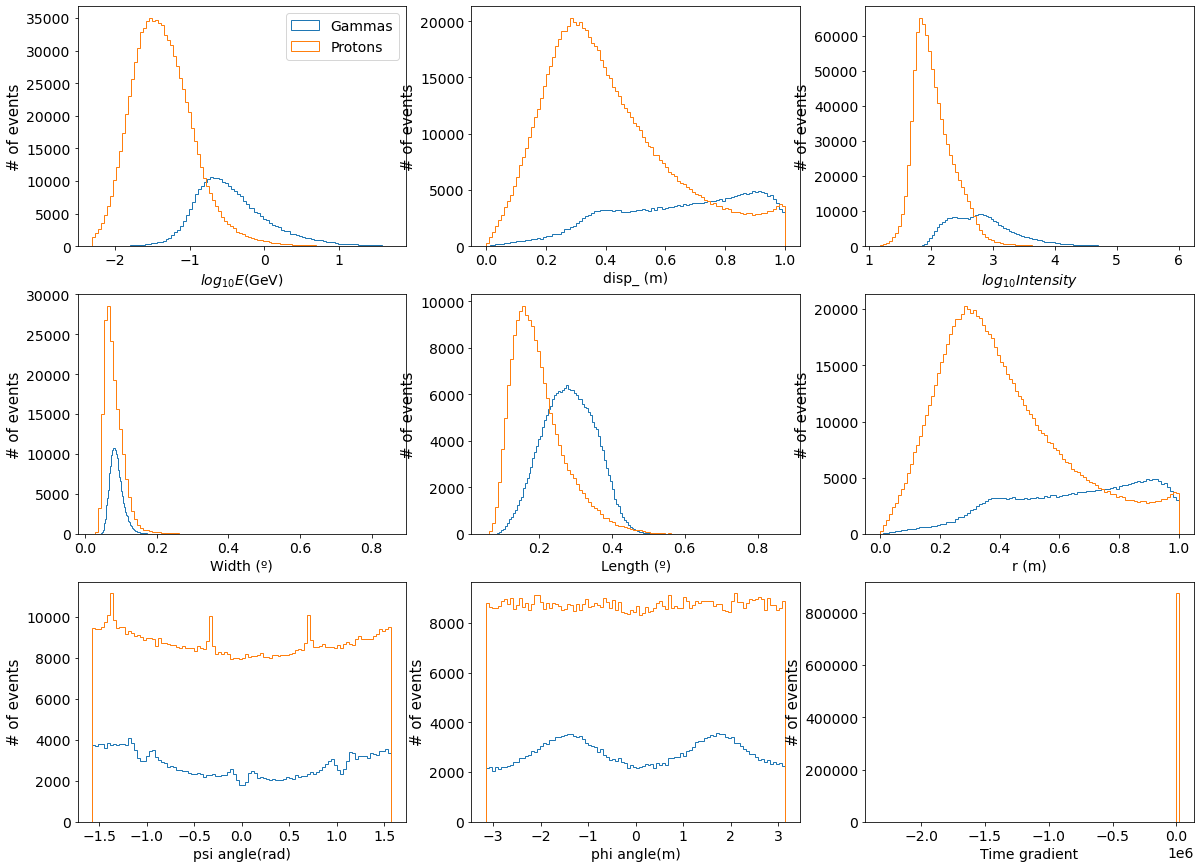

In [28]:
# Let's take a look to the results


lstplot.plot_features(data_dl2)
                      


## Energy reconstruction





(<Figure size 864x576 with 4 Axes>,
 array([[<AxesSubplot:ylabel='$(\\Delta E/E)_{68}$'>,
         <AxesSubplot:xlabel='log(mc energy/[TeV])', ylabel='log(reco energy/[TeV])'>],
        [<AxesSubplot:xlabel='$E_R$ [TeV]', ylabel='Energy bias'>,
         <AxesSubplot:>]], dtype=object))

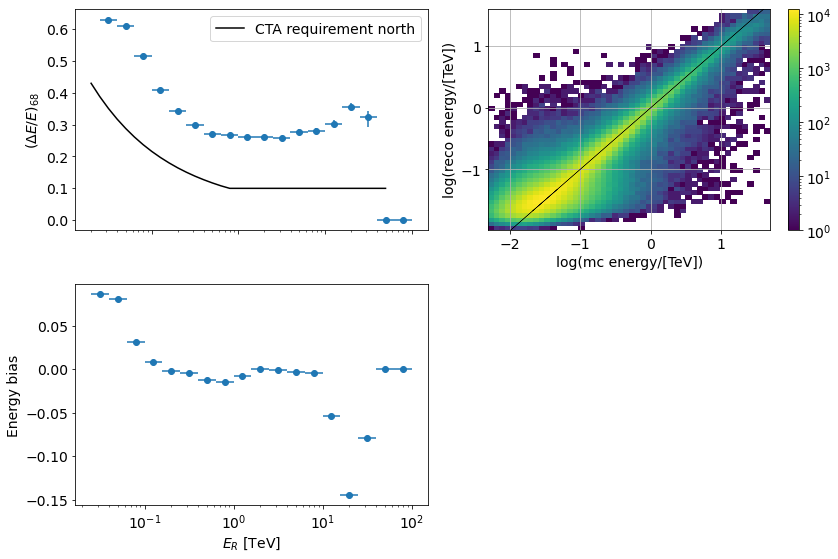

In [29]:
lstplot.energy_results(data_dl2)

# Disp reconstruction

mu = 0.0011233709074459982
 sigma = 0.15766431007813667


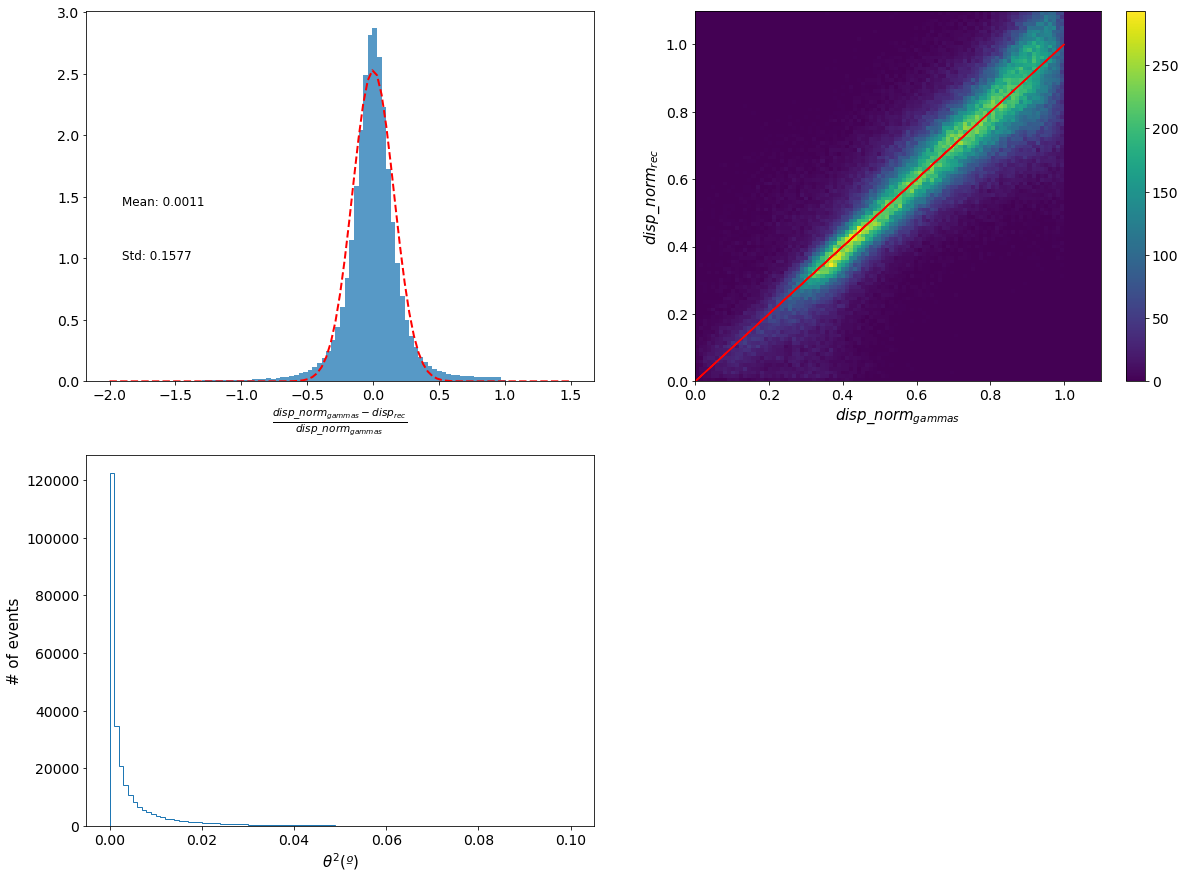

In [30]:
lstplot.plot_disp(data_dl2)

# Reconstructed source position in camera coordinates

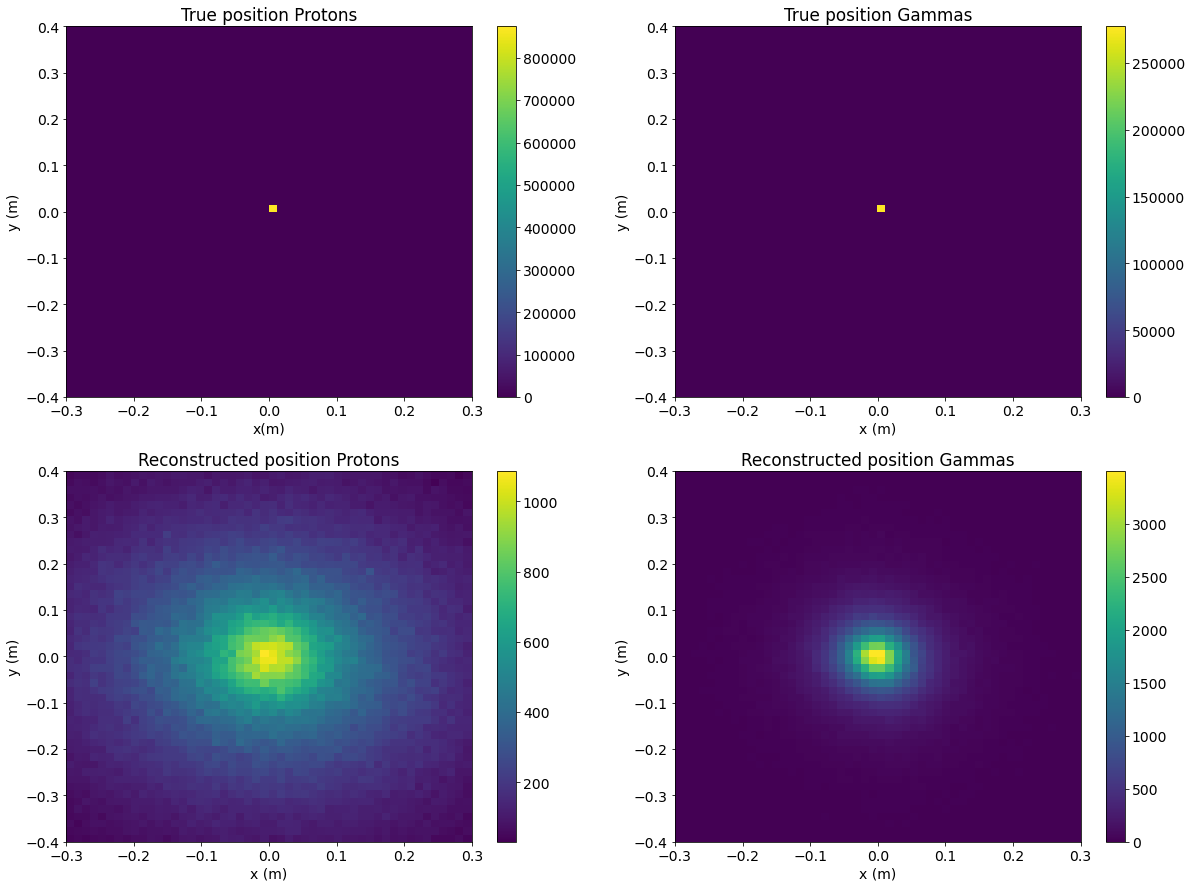

In [31]:
lstplot.plot_pos(I''ldata_dl2)

# Gammaness

Text(0.5, 0, 'Gammaness')

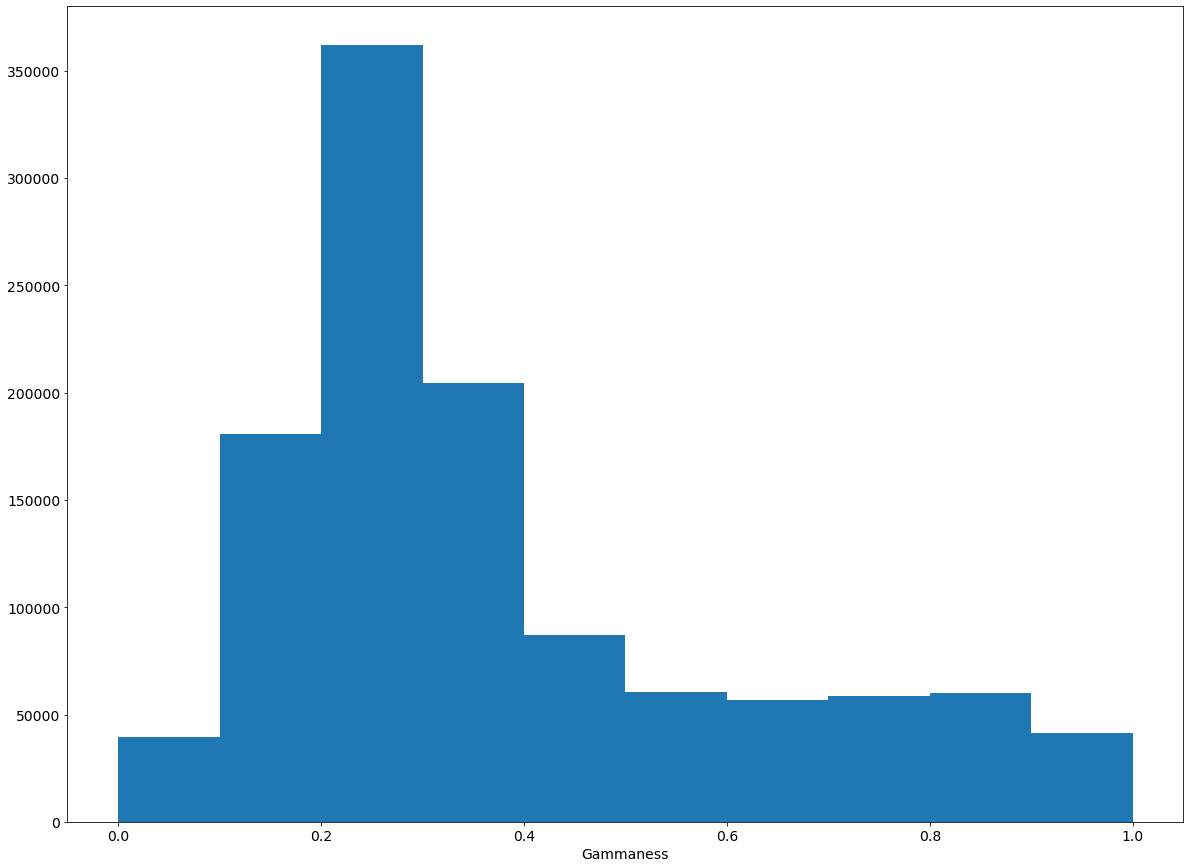

In [32]:
fig, ax = plt.subplots()

ax.hist(data_dl2['gammaness'])
ax.set_xlabel('Gammaness')
